In [14]:
from import_data import *
from constants import *
from CRPS import *
import matplotlib.pyplot as plt
import numpy as np
import sklearn
plt.style.use('ggplot')

# set up parameters based on A4 paper
plt.rcParams.update({
    "savefig.dpi": 300,
    "font.size": 10,  # Font size for text (like in the report)
    # "axes.labelsize": 8,  # Font size for x-axis labels
})
# helper function
def fig_size(x_ratio=1.0, y_ratio=1.0):
    """
    Assuming an A4 paper size, this function returns a tuple
    representing the figure size in inches.
    parameters:
    x_ratio: float, ratio of the width relative to A4 width
    y_ratio: float, ratio of the height relative to A4 height
    """
    A4_WIDTH = 6.202  # A4 paper text width in inches
    A4_HEIGHT = 9.3562  # A4 paper text height in inches
    if x_ratio <= 0 or y_ratio <= 0:
        raise ValueError("Ratios must be positive numbers.")
    return (A4_WIDTH * x_ratio, A4_HEIGHT * y_ratio)

In [15]:
# Prepare the data
test_labels = pd.read_csv(fr"Data\RUL_{DATASET_NAME}.txt", header=None)
df_train_grouped = df_train.groupby('engine')
df_train_last_cycle = df_train_grouped.max()['cycle']
df_train_with_labels = df_train.copy()
df_train_with_labels['RUL'] = df_train_with_labels.apply(lambda row: df_train_last_cycle[row['engine']] - row['cycle'], axis=1)

sensor_columns = df_train_with_labels.columns[5:-1]  # Exclude 'engine', 'cycle', and 'RUL'
uncorrelated_sensors = ["T2","P2", "P15", "epr", "farB", "Nf_dmd", "PCNfR_dmd"]
sensors_of_interest = [sens for sens in sensor_columns if sens not in uncorrelated_sensors]

# Cap RUL to 125
df_train_with_labels['RUL'] = df_train_with_labels['RUL'].clip(upper=125)
test_labels = test_labels.clip(upper=125)

## Train validation split
# From the different engines, choose 2 engines for validation. The rest will be used for training.
from sklearn.model_selection import train_test_split
train_engines, val_engines = train_test_split(df_train_with_labels['engine'].unique(), test_size=2/100, random_state=42)
# Create train and validation sets
df_train_set = df_train_with_labels[df_train_with_labels['engine'].isin(train_engines)]
df_val_set = df_train_with_labels[df_train_with_labels['engine'].isin(val_engines)]
df_test_grouped = df_test.groupby('engine')
df_test_last = df_test_grouped.last()

In [6]:
RFR = sklearn.ensemble.RandomForestRegressor(n_estimators=80, random_state=42, n_jobs=-1)
RFR.fit(df_train_set[sensors_of_interest], df_train_set.RUL)
RFR_predictions = RFR.predict(df_val_set[sensors_of_interest])
RMSE_ = sklearn.metrics.root_mean_squared_error(df_val_set.RUL, RFR_predictions)
print(f"RMSE on validation set: {RMSE_:.2f}")

RMSE on validation set: 19.26


In [16]:
RFR = sklearn.ensemble.RandomForestRegressor(n_estimators=80, random_state=42, n_jobs=-1)
RFR.fit(df_train_set[sensors_of_interest], df_train_set.RUL)
RFR_predictions = RFR.predict(df_test_last[sensors_of_interest])
RMSE_test = sklearn.metrics.root_mean_squared_error(test_labels, RFR_predictions)
R2_SCORE_ = sklearn.metrics.r2_score(test_labels, RFR_predictions)
CRPS_ = CRPS({0:test_labels[0].to_numpy().flatten()}, {0:RFR_predictions})
print(f"CRPS on test set: {CRPS_}")
print(f"R2 score on test set: {R2_SCORE_:.2f}")
print(f"RMSE on test set: {RMSE_test:.2f}")

CRPS on test set: (np.float64(22.617631249999985), np.float64(25.823649375))
R2 score on test set: 0.82
RMSE on test set: 17.23


Text(0, 0.5, 'Predicted RUL')

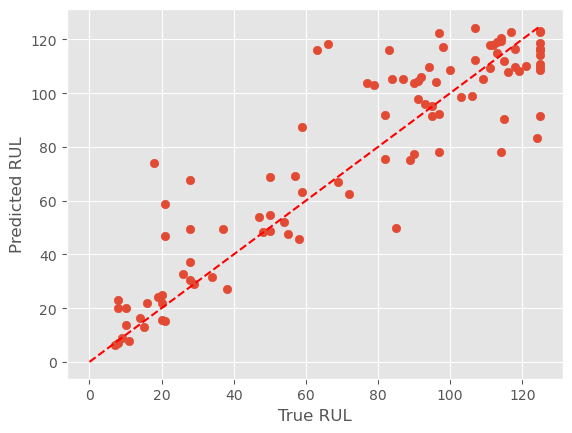

In [12]:
plt.scatter(test_labels, RFR_predictions)
plt.plot([0, 125], [0, 125], color='red', linestyle='--', label='y=x')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")